<h1 align="center"> Credit Fraud Catboost Model</h1>

<h1 align="center"> Erinç Koç </h1>

<h2 align="center"> Outline </h2><br>

### Table of Contents

* [1) Import Libraries & Data ](#chapter1)
* [2) Feature Engineering and Preprocess](#chapter2)
    * [2.1) Get Type fo Columns](#section_2_1)
    * [2.2) Drop Rows & Columns](#section_2_2)
    * [2.3) Handle Missing Values](#section_2_3)
    * [2.4) Divide into Train and Test Sets](#section_2_4)
    * [2.5) Generate New Features](#section_2_5)
        * [2.5.1) Otherization](#section_2_5_1)  
        * [2.5.2) New features Based on Highly Correlated Ones](#section_2_5_2)  
* [3) Generate Decision Metrics](#chapter3)
    * [3.1) Feature Importance](#section_3_1)
    * [3.2) Confusion Matrix](#section_3_2) 
    * [3.3) ROC Curve](#section_3_3)  
* [4) Training & Predictions](#chapter4)
    * [4.1) Training](#section_4_1)
    * [4.2) Prediction](#section_4_2)         
        
        


##### Data analysis part of this data is available on my github repo. https://github.com/e181337/data_analysis contains data analysis part.

### 1) Import Libraries & Data<a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import random
import math
import scipy.stats as stats
import matplotlib.cm as cm
import sys
import warnings
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, roc_auc_score, log_loss
from sklearn import metrics

In [2]:
### display-related options
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_seq_items', 2000)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
### ignore warning
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [4]:
### import data
data_master = pd.read_csv('CaseStudy_AnomalyDetection_202012.csv', sep=';')

In [5]:
### import column heading
column_name = pd.read_csv('column_name.csv', sep=';')

In [6]:
### change column names
data_master.rename(columns=dict(zip(column_name.column_old, column_name.column_new)), inplace=True)

In [7]:
data_master.head()

,Target,Restructured Credit Request YN,Customer GBF,CC_Num_of_application_L6M + LO_Num_of_application_L6M + MO_Num_of_application_L6M + OD_Num_of_application_L6M,KKB Bureau Score,CC Total Payment of all Credit cards,CC_Num_of_application_L1M + LO_Num_of_application_L1M + OD_Num_of_application_L1M,Employers Address YN,Branch and work adresses are the same,Main and application branch codes are the same,Müşteri Dönem Aktif,Monthly Family Income,OD Number of months in 1 delay_L24M,OD Number of months in 2 delay_L12M,CC Number of months in 2 delay_L24M,Kullandırım Hazırlık,Şube Müdürü Görüşü,Şube Kaps Kontrolü,CC Tot Limit YTL,Total_of_Monthly_Instalment / Total_Assets,CC_Total_Payment_of_all_Credit_cards / CC_Total_Balance_of_All_Credit_Cards,Worst Card Status ALL,Home Phone YN,Şube Pazarlama Eksiklik Görüşü,GUA_Num Unpaid Cheques L6M,Number of Limit Increase Rejects in L3M,Total_of_Monthly_Instalment / Monthly Net Income,Residential Status,Max Delinquency Status L6M,Num Unpaid Notes L7M_L12M,Aktif Vadeli Grup,Current Payment Status,Bayii Bekleme Havuzu,Home adress district code,Level of Education,Branch and home adresses have the same city code,LO Tot Balance in Litigation,Num Unpaid Cheques L13M-L24M,MO_Maximum_Mortgage_Limit / Monthly Net Income,GM Kullandırım İşlem,Preapproval_Credit_Type
0,0,N,X,3.00,1331.00,0.00,1.00,Y,Y,Y,1,4000.00,NaN,NaN,NaN,1,0,0,9050.00,0.00,0.00,N,N,0,0.00,NaN,0.36,1.00,0.00,0.00,0,NaN,0,14.00,L,Y,0.00,0.00,0.00,0,NaN
1,0,N,X,4.00,1174.00,6002.00,1.00,Y,Y,Y,1,5900.00,NaN,NaN,NaN,1,0,0,16710.00,2.87,1.01,N,N,0,0.00,NaN,0.48,5.00,0.00,0.00,0,0,0,8.00,O,Y,0.00,0.00,0.00,0,NaN
2,0,N,X,2.00,980.00,2455.00,0.00,Y,Y,Y,1,2000.00,NaN,NaN,NaN,1,0,0,3600.00,0.00,0.69,N,N,0,0.00,NaN,0.00,5.00,0.00,0.00,0,NaN,0,22.00,L,Y,0.00,0.00,0.00,0,NaN
3,0,N,X,6.00,1070.00,632.00,0.00,Y,N,Y,1,2971.00,NaN,NaN,NaN,1,0,0,2750.00,0.00,3.16,N,N,0,0.00,NaN,0.25,1.00,0.00,0.00,0,NaN,0,0.00,L,N,0.00,0.00,0.00,0,NaN
4,0,N,X,0.00,1257.00,200.00,0.00,Y,Y,Y,1,3500.00,NaN,NaN,NaN,1,0,0,1300.00,0.00,0.20,N,N,0,0.00,NaN,0.00,5.00,0.00,0.00,0,1,0,22.00,I,Y,0.00,0.00,0.00,0,NaN


In [8]:
### rename the columns in order to shorten it
data_master.rename(columns={ data_master.columns[3]: 'CC_LO_MO_OD_L6M'}, inplace = True)
data_master.rename(columns={ data_master.columns[6]: 'CC_LO_OD_L1M'}, inplace = True)
data_master.rename(columns={ data_master.columns[20]: 'CC_Total_Payment_Balance_Rate'}, inplace = True)

In [9]:
data_master.head()

,Target,Restructured Credit Request YN,Customer GBF,CC_LO_MO_OD_L6M,KKB Bureau Score,CC Total Payment of all Credit cards,CC_LO_OD_L1M,Employers Address YN,Branch and work adresses are the same,Main and application branch codes are the same,Müşteri Dönem Aktif,Monthly Family Income,OD Number of months in 1 delay_L24M,OD Number of months in 2 delay_L12M,CC Number of months in 2 delay_L24M,Kullandırım Hazırlık,Şube Müdürü Görüşü,Şube Kaps Kontrolü,CC Tot Limit YTL,Total_of_Monthly_Instalment / Total_Assets,CC_Total_Payment_Balance_Rate,Worst Card Status ALL,Home Phone YN,Şube Pazarlama Eksiklik Görüşü,GUA_Num Unpaid Cheques L6M,Number of Limit Increase Rejects in L3M,Total_of_Monthly_Instalment / Monthly Net Income,Residential Status,Max Delinquency Status L6M,Num Unpaid Notes L7M_L12M,Aktif Vadeli Grup,Current Payment Status,Bayii Bekleme Havuzu,Home adress district code,Level of Education,Branch and home adresses have the same city code,LO Tot Balance in Litigation,Num Unpaid Cheques L13M-L24M,MO_Maximum_Mortgage_Limit / Monthly Net Income,GM Kullandırım İşlem,Preapproval_Credit_Type
0,0,N,X,3.00,1331.00,0.00,1.00,Y,Y,Y,1,4000.00,NaN,NaN,NaN,1,0,0,9050.00,0.00,0.00,N,N,0,0.00,NaN,0.36,1.00,0.00,0.00,0,NaN,0,14.00,L,Y,0.00,0.00,0.00,0,NaN
1,0,N,X,4.00,1174.00,6002.00,1.00,Y,Y,Y,1,5900.00,NaN,NaN,NaN,1,0,0,16710.00,2.87,1.01,N,N,0,0.00,NaN,0.48,5.00,0.00,0.00,0,0,0,8.00,O,Y,0.00,0.00,0.00,0,NaN
2,0,N,X,2.00,980.00,2455.00,0.00,Y,Y,Y,1,2000.00,NaN,NaN,NaN,1,0,0,3600.00,0.00,0.69,N,N,0,0.00,NaN,0.00,5.00,0.00,0.00,0,NaN,0,22.00,L,Y,0.00,0.00,0.00,0,NaN
3,0,N,X,6.00,1070.00,632.00,0.00,Y,N,Y,1,2971.00,NaN,NaN,NaN,1,0,0,2750.00,0.00,3.16,N,N,0,0.00,NaN,0.25,1.00,0.00,0.00,0,NaN,0,0.00,L,N,0.00,0.00,0.00,0,NaN
4,0,N,X,0.00,1257.00,200.00,0.00,Y,Y,Y,1,3500.00,NaN,NaN,NaN,1,0,0,1300.00,0.00,0.20,N,N,0,0.00,NaN,0.00,5.00,0.00,0.00,0,1,0,22.00,I,Y,0.00,0.00,0.00,0,NaN


### 2) Feature Engineering and Preprocess<a class="anchor" id="chapter"></a>

#### 2.1) Get Type fo Columns <a class="anchor" id="section_2_1"></a>

In [10]:
def get_categorical_numerical_columns(df):
    """Get the categorical and numerical columns to be used as features"""

    #all_columns = list(df.columns)
    
    # analysis columns, not to be used for training
    drop_columns = ['Preapproval_Credit_Type', 'Bayii Bekleme Havuzu']

    # target column
    target_columns = ['Target'] 
    
    # categorical columns
    set_categorical = ['Home adress district code', 'Max Delinquency Status L6M', 'Residential Status']   
    possible_cat = list(set([col for col in df.columns
                 if df.dtypes[f"{col}"] == np.object] + set_categorical) - set(drop_columns + target_columns))
       
    # numerical columns
    possible_num = list(set(df.select_dtypes([np.number]).columns) - set(['Home adress district code'] + drop_columns + target_columns + possible_cat))
    
 
    
    return possible_cat, possible_num, drop_columns, target_columns

In [11]:
possible_cat, possible_num, drop_columns, target_columns = get_categorical_numerical_columns(data_master)

#### 2.2) Drop Rows & Columns <a class="anchor" id="section_2_2"></a>

Feature that are believed to have no information related with problem will be dropped from data 

In [12]:
### drop empty rows
data_master = data_master.drop(data_master[(data_master['Restructured Credit Request YN'].isnull()) & 
        (data_master['CC_LO_MO_OD_L6M'].isnull()) & 
        (data_master['Customer GBF'].isnull()) & (data_master['KKB Bureau Score'].isnull())].index)

In [13]:
### drop empty columns 
data_master = data_master.drop(drop_columns, axis=1)

#### 2.3) Handle Missing Values <a class="anchor" id="section_2_3"></a>

In [14]:
for col in possible_num:
    data_master[col].fillna(0, inplace=True)

In [15]:
for col in possible_cat:
    data_master[col] = data_master[col].astype(str)
    data_master[col].fillna('Unknown', inplace=True)

#### 2.4) Divide into Train and Test Sets <a class="anchor" id="section_2_4"></a>

In [16]:
### get feature columns and target column from the dataset
def get_X_and_y(df, feature_columns, target_column):
    """Get feature columns and target column"""

    X = df[feature_columns]
    y = df[target_column].astype(int)
    return X, y

In [17]:
### get X and y
feature_columns = possible_cat + possible_num
X, y = get_X_and_y(data_master, feature_columns, target_columns)

In [18]:
### get train and test
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1)

#### 2.5) Generate New Features <a class="anchor" id="section_2_5"></a>

##### 2.5.1) Otherization  <a class="anchor" id="section_2_5_1"></a>

##### Otherization is applied for categorical columns which yields high distinct values. Moreover, otherization is as applied based on values of training set  in order to prevent data leakage.

In [19]:
city_list = X_train['Home adress district code'].value_counts(normalize = True).head(20).index
X_train['city_other'] = X_train['Home adress district code']
X_test['city_other'] = X_test['Home adress district code']
X_train.loc[~X_train['Home adress district code'].isin(city_list), 'city_other'] = "other"
X_test.loc[~X_test['Home adress district code'].isin(city_list), 'city_other'] = "other"

##### 2.5.2) New features Based on Highly Correlated Ones <a class="anchor" id="section_2_5_2"></a>

Count and mean is added to increase model success. Otherization methods actually cause loss of data so that these features are used in this part to generate new ones. 

In [20]:
temp = pd.DataFrame(X_train['Home adress district code'].value_counts().reset_index().values, columns=["Home adress district code", "city_count"])
X_train = pd.merge(X_train, temp, on='Home adress district code', how='left')    
X_test = pd.merge(X_test, temp, on='Home adress district code', how='left')        
temp = X_train.groupby(['Müşteri Dönem Aktif', 'Home adress district code']).\
agg({'Current Payment Status' : 'count', 
     'OD Number of months in 1 delay_L24M' : 'mean',
     'OD Number of months in 2 delay_L12M' : 'mean',
     'CC Number of months in 2 delay_L24M' : 'mean'}).reset_index()
temp.columns = ['Müşteri Dönem Aktif', 'Home adress district code', 
                'Current Payment Status_count',
               'OD Number of months in 1 delay_L24M_mean',
               'OD Number of months in 2 delay_L12M_mean',
               'CC Number of months in 2 delay_L24M_mean']
new_columns = ['Current Payment Status_count',
               'OD Number of months in 1 delay_L24M_mean',
               'OD Number of months in 2 delay_L12M_mean',
               'CC Number of months in 2 delay_L24M_mean']
X_train = pd.merge(X_train, temp, on=['Müşteri Dönem Aktif', 'Home adress district code'], how='left')
X_test = pd.merge(X_test, temp, on=['Müşteri Dönem Aktif', 'Home adress district code'], how='left')    
X_test[new_columns] = X_test[new_columns].fillna(0)
X_train = X_train.drop('Home adress district code', axis=1)
X_test = X_test.drop('Home adress district code', axis=1)

### 3) Generate Decision Metrics<a class="anchor" id="section_3"></a>

#### 3.1) Feature Importance <a class="anchor" id="section_3_1"></a>

In [21]:
def plot_feature(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('Catboost Features')
    plt.tight_layout()
    plt.show()

#### 3.2) Confusion Matrix<a class="anchor" id="section_3_2"></a>

In [22]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # labels, title and ticks
    sns.set()
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['non fraud', 'fraud']); ax.yaxis.set_ticklabels(['fraud', 'non fraud']);

#### 3.3) ROC Curve<a class="anchor" id="section_3_3"></a>

In [23]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(10, 10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#### It should be stated that the data set is imbalanced. Fraud cases constitute a minor part of the data set. Therefore, the main decision metric will be AUC score. 

### 4) Training & Predictions <a class="anchor" id="section_4"></a>

I have already applied experimental design to find the  best parameter set. Therefore,  these parameter set will be used in this part. 

##### 4.1) Training <a class="anchor" id="section_4_1"></a>

In [24]:
param_0 = {
    
    'loss_function': 'Logloss',
    'learning_rate': 0.1408257096589506,
    'iterations': 800,
    'depth': 9,
    'border_count': 65,
    'eval_metric': 'AUC',
    'l2_leaf_reg': 8 
}

In [25]:
possible_cat_val = list(set(possible_cat) - set(['Home adress district code'])) + ['city_other']
model = CatBoostClassifier(**param_0)  

In [26]:
###no eval set used in this part
model.fit(X_train, y_train,  ##eval_set=(X_dev, y_dev), 
            cat_features=possible_cat_val, logging_level="Silent")

##### 4.2) Prediction <a class="anchor" id="section_4_2"></a>

In [27]:
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
y_pred = pd.DataFrame((preds>= 0.5).astype(int))
roc_auc = metrics.auc(fpr, tpr)
print("roc_auc score", roc_auc)

roc_auc score 0.8196078962822424


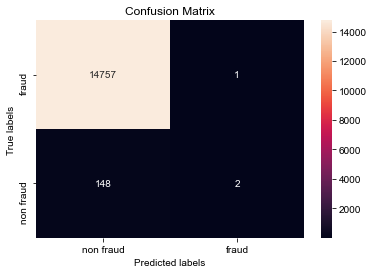

In [28]:
plot_confusion_matrix(y_test, y_pred)

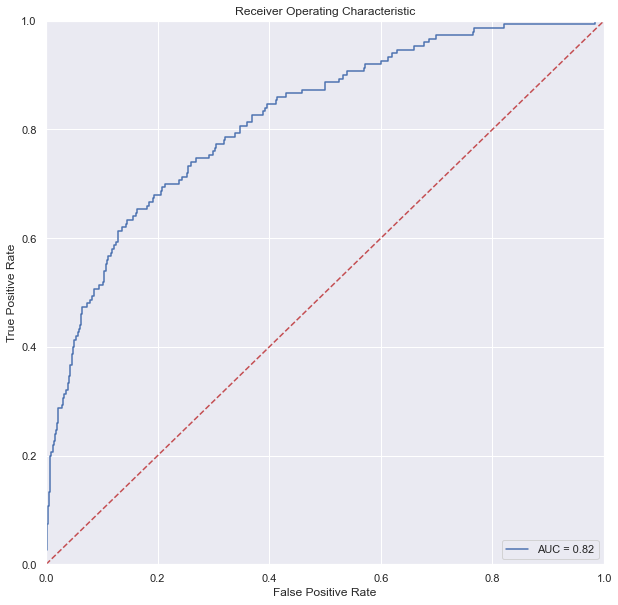

In [29]:
plot_roc_curve(fpr, tpr, roc_auc)

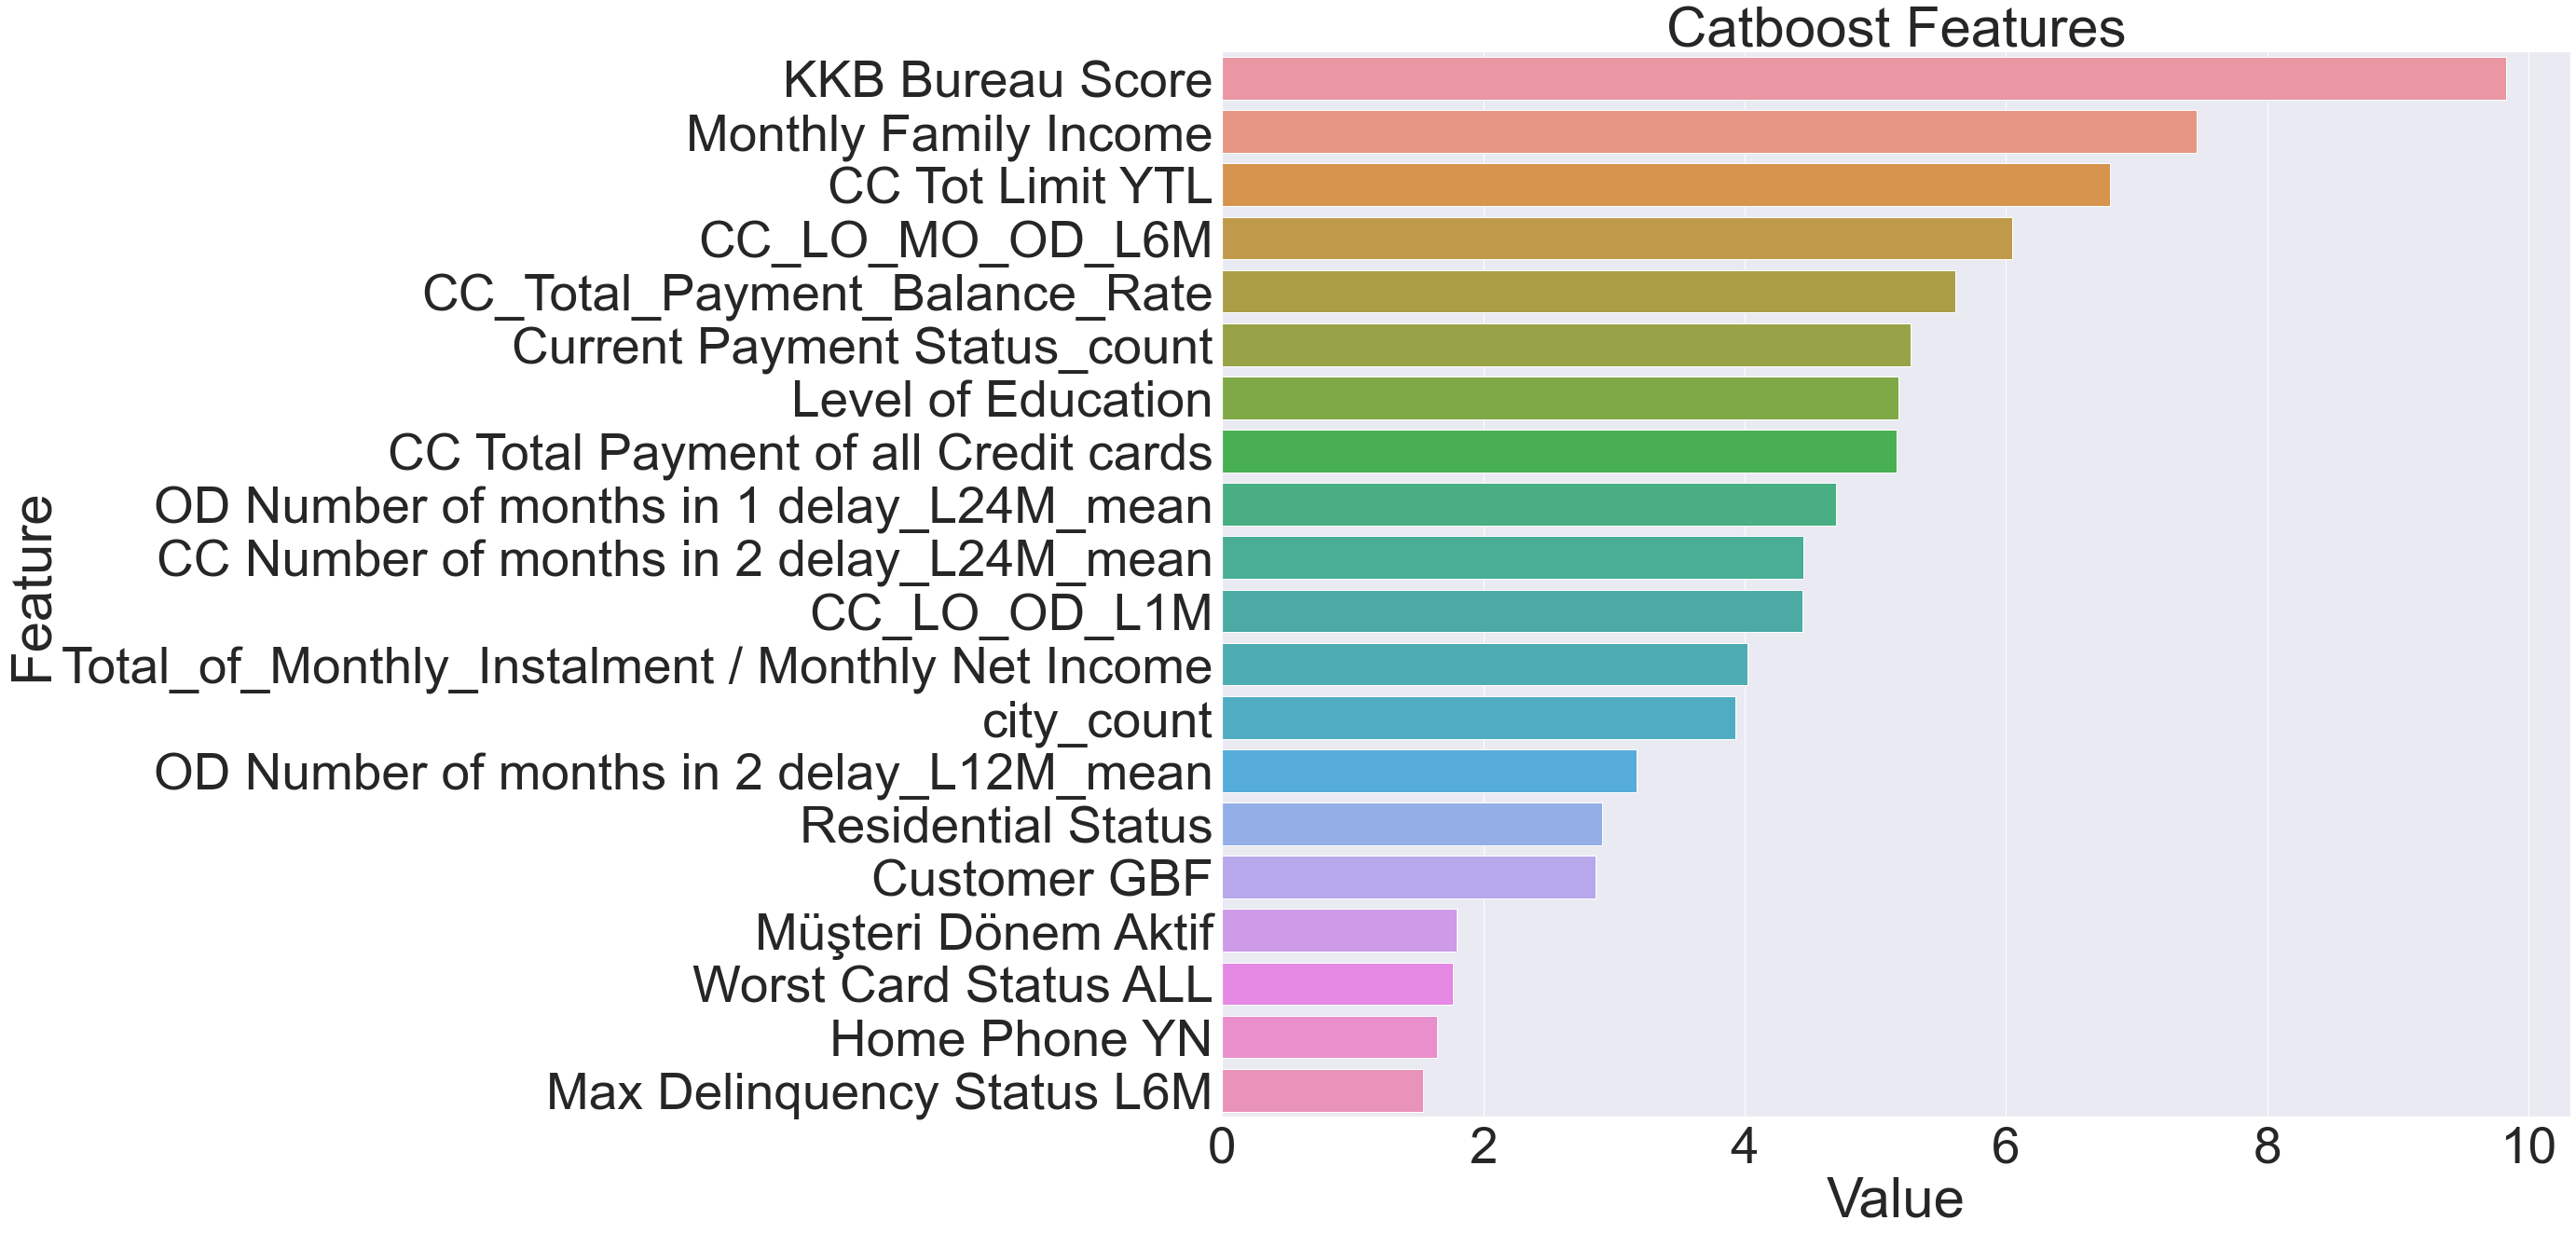

In [30]:
plot_feature(model, X_test , num = 20)